![logo](../pics/imageJUPYTER.png)

# ImageJ on Jupyter

This notebook explores how to mix the usage of *python* and *ImageJ*. It uses a beakerx-groovy kernel. [Beakerx](http://beakerx.com/) allows to use python-cells, allowing access to python libraries like [scipy, numpy and matplotlib](https://www.scipy.org/). [Groovy](http://www.groovy-lang.org/) allow to access the ImageJ library. Data can be exchanged between the groovy and the python cells via the [auto-translation](http://nbviewer.jupyter.org/github/twosigma/beakerx/blob/master/doc/groovy/GeneralAutotranslation.ipynb) provided by beakerx.

## Important Note

The way to use python with ImageJ proposed here might not be the best possible way. 
* You will not be able to use ['SciJava @Parameter annotations'](https://imagej.net/Script_Parameters). 
* You will often have to convert data manually when accessing it from cells using different languages. 

Before you decide to follow the example of this notebook please check out:
* [analysis-with-imagej-and-visualization-in-the-jupyter-notebook](https://forum.image.sc/t/analysis-with-imagej-and-visualization-in-the-jupyter-notebook/11052) 

## Setting up the environment for ImageJ

Using the beakerx-magic we add the jar-files from the FIJI installation, including those of bioformats, to the classpath. Change the class to match the location of FIJI on your machine!

In [1]:
%classpath add jar ../Fiji.app/jars/*
%classpath add jar ../Fiji.app/jars/bio-formats/*

My FIJI installation contains [simpleitk](https://imagej.net/ITK), the LD_LIBRARY_PATH must contain the folder containing the needed native library, otherwise the initialization of ImageJ will fail.
I'm not sure that the cell below works as expected, do I finished by copying the `libSimpleITKJava.so` to a folder already contained in the LD_LIBRARY_PATH

In [2]:
currentPath = System.getProperty("java.library.path")
newPath = currentPath + ":../Fiji.app/lib/linux64"
System.setProperty( "java.library.path", newPath )

/usr/java/packages/lib/amd64:/usr/lib64:/lib64:/lib:/usr/lib

## ImageJ2

Now we create an ImageJ2 instance:

In [3]:
import net.imagej.ImageJ
ij2 = new ImageJ()

net.imagej.ImageJ@5861b5ac

We use the ImageJ2 instance ij2 to write the obligatory `Hello World`.

In [4]:
ij2.log().info("Hello ImageJ2! Welcome on Jupyter!")

[INFO] Hello ImageJ2! Welcome on Jupyter!


null

Now let us open an image via ImageJ2. In order to easily display the image, we wrap it in an ImageJ1 ImagePlus and get the BufferedImage from it.

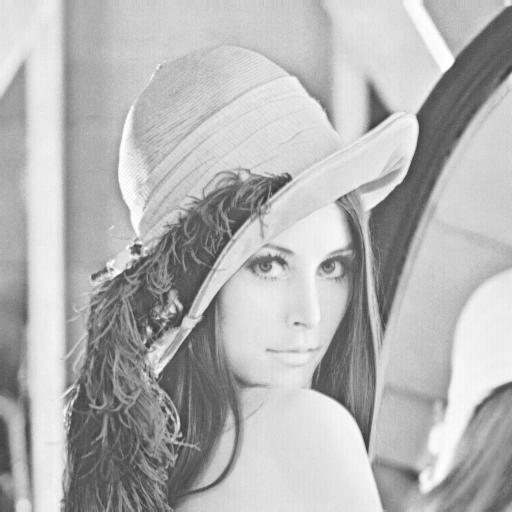

In [5]:
import net.imglib2.img.display.imagej.ImageJFunctions

image = ij2.io().open("http://wsr.imagej.net/images/lena-std.tif")
ip = ImageJFunctions.wrap(image, "lena")
Image(ip.getBufferedImage())

We can also open a view on the image in its own ImageJ window. This only works when we are running in an environment with a graphical user interface, i.e. not with mybinder.

In [6]:
import net.imglib2.img.display.imagej.ImageJFunctions
ImageJFunctions.show(image)

img["Image 0" (-3), 8-bit, 512x512x3x1x1]

## ImageJ1

Now let us say hello to ImageJ1.

In [7]:
ij1 = new ij.ImageJ();
ij.IJ.log("Hello ImageJ1");

null

We open an image via ImageJ1 and display it in the notebook.

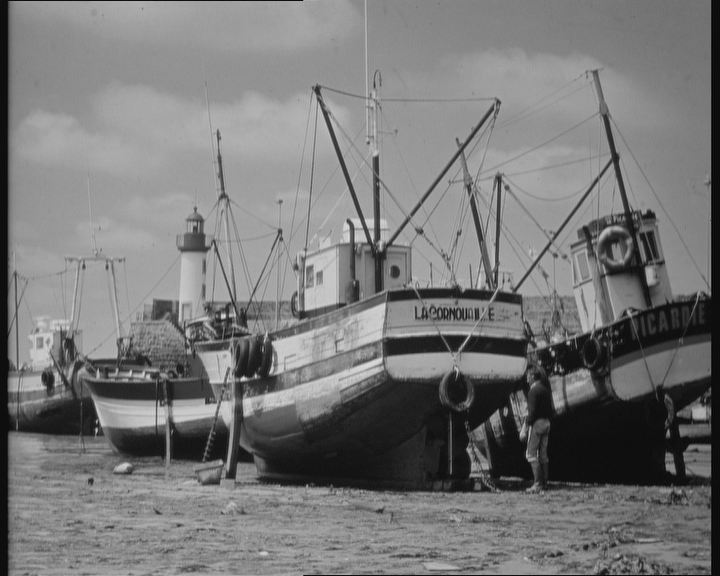

In [8]:
image =  ij.IJ.openImage("http://wsr.imagej.net/images/boats.gif");
bufferedImage = image.getBufferedImage();
Image(bufferedImage)

In order to use the image data in a python cell later, we copy it into attributes of the beakerx object.

## Transfering data

In [9]:
beakerx.width = image.getWidth()
beakerx.height = image.getHeight()
beakerx.pixels = image.getProcessor().getPixels()
print([beakerx.width, beakerx.height])
Collections.min(beakerx.pixels)

[720, 576]

-128

## Python

Say hello to python. The beakerx magic `python` allows to create a cell excuting python code.

In [10]:
%%python
print("Hello python!")

Hello python!


We import numpy and matplotlib. We access the image data via the attributes of the beakerx object, which we set before in a groovy cell. The pixel values will be interpreted as signed bytes, so we convert them back to `uint8`. The pixel values come in a linear list from which we create a numpy array. We shape the linear array to 2D. Note the order of the dimensions. 
The `amin` function shows that the smallest value in the image is positive (3).
Finally we use matplotlib to display the image in the notebook.

3


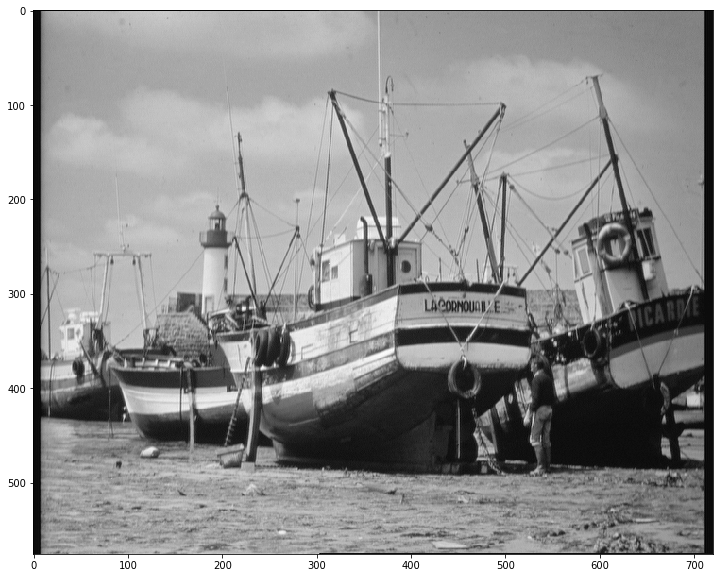

In [31]:
%%python
import numpy
from beakerx import beakerx
from matplotlib import pyplot as plt

imArray = numpy.array(beakerx.pixels, dtype='uint8')
imArray = numpy.reshape(imArray, (beakerx.height, beakerx.width)) 
print(numpy.amin(imArray))
plt.figure(figsize=(14, 10))
plt.imshow(imArray, interpolation='none', cmap='gray')
plt.show()

If after running the cell above the image does not show, run it again or reduce the size of the figure in the command `plt.figure(figsize=(14, 10))`

Now let's modify the image in python and then display it with ImageJ2 again. Normally the 2d matrix would become a 2D ArrayList in groovy, but we flatten it so that we can directly rebuild an image in ImageJ from a linear ArrayList converted to a byte-array.

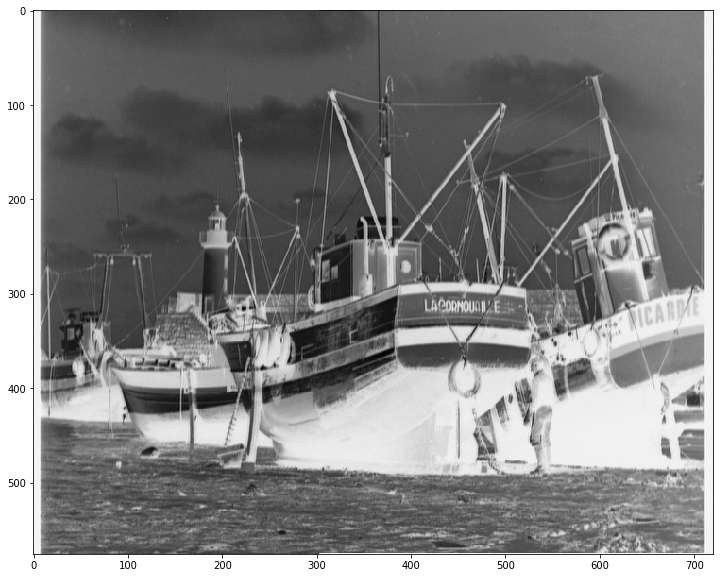

In [32]:
%%python
max = numpy.iinfo(imArray.dtype).max
invertedImage = max - imArray
plt.figure(figsize=(14, 10))
plt.imshow(invertedImage, interpolation='none', cmap='gray')
plt.show()
beakerx.invertedPixels = invertedImage.flatten()

## Back to groovy and ImageJ

### ImageJ1

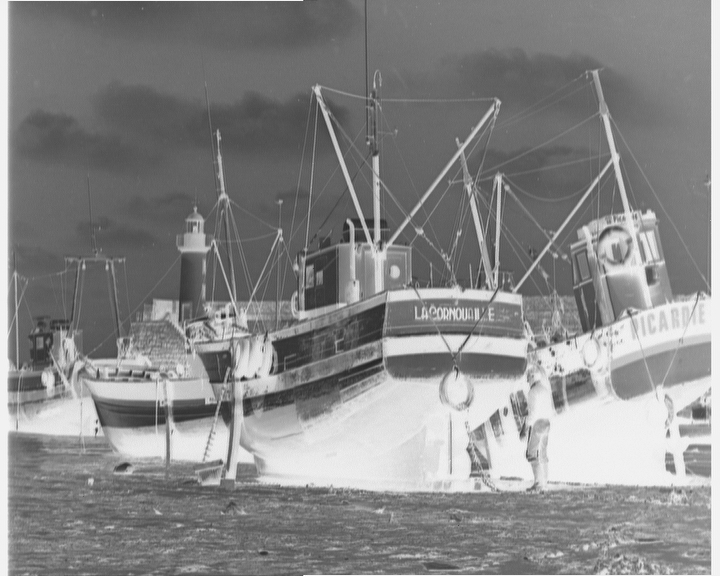

In [13]:
import ij.process.ByteProcessor
pixels = beakerx.invertedPixels
imp = new ByteProcessor(beakerx.width, beakerx.height)
imp.setPixels((byte[])pixels.toArray())
ip = new ij.ImagePlus("boats", imp)
Image(ip.getBufferedImage())

### ImageJ2

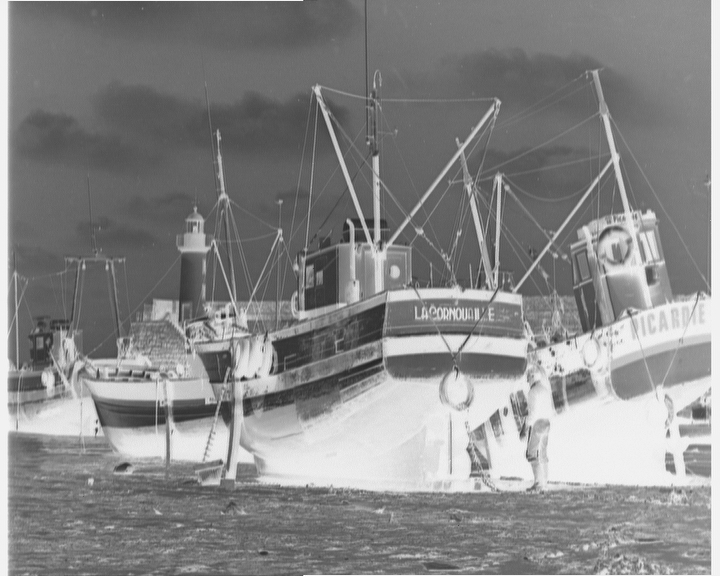

In [28]:
import net.imglib2.type.numeric.integer.ByteType
import net.imglib2.img.basictypeaccess.array.ByteArray
import net.imglib2.img.array.ArrayImg
import net.imglib2.img.array.ArrayImgs
import net.imglib2.img.display.imagej.ImageJFunctions

bytes = (byte[])pixels.toArray()
ArrayImg< ByteType, ByteArray > img = ArrayImgs.unsignedBytes(bytes, beakerx.width, beakerx.height);
ip = ImageJFunctions.wrap(img, "inverted boats")
Image(ip.getBufferedImage())